# Stokes flow

Flows at very low Reynolds numbers are often called *Stokes flow*. If the Navier-Stokes equations are nondimensionalized using the characteristic velocity $U$ and length scale $L$, the equations can be simplified as

```{math}
:label: eq:NS_nondim
\begin{aligned}
\mathrm{Re}\left(  \frac{\partial \boldsymbol{\tilde{u}}}{\partial \tilde{t}} + (\boldsymbol{\tilde{u}} \cdot \tilde{\nabla})\boldsymbol{\tilde{u}} \right) &= -\tilde{\nabla} \tilde{p} + \tilde{\nabla} ^2 \boldsymbol{\tilde{u}}, \\
  \tilde{\nabla} \cdot \boldsymbol{\tilde{u}} &= 0,
\end{aligned}
```

where $\boldsymbol{\tilde{u}} = \boldsymbol{u}/U$, $\tilde{t}=tU/L$, $\tilde{\boldsymbol{x}}=\boldsymbol{x}/L$, $\tilde{p}=p/(\mu U /L)$ and $\mathrm{Re}=\rho U L / \mu$. The spatial derivative is taken with respect to $\tilde{\boldsymbol{x}}$, which explains the tilde on the nabla operator. The assumption for Stokes flow is that the Reynolds number is very small $\mathrm{Re} << 1$, such that the acceleration term on the left hand side of Navier-Stokes can be neglected. Stokes flow is therefore governed, on dimensional form, by

```{math}
:label: eq:Stokes
\begin{aligned}
\mu\nabla ^2 \boldsymbol{u} &= {\nabla} {p} ,  \\
  {\nabla} \cdot \boldsymbol{u} &= 0.
\end{aligned}
```

Here the first (vector) equation is a momentum equation, whereas the second $\nabla \cdot \boldsymbol{u}$ usually is referred to as the continuity eqaution.

Conveniently there is a [FEniCS demo](https://fenicsproject.org/docs/dolfin/latest/python/demos/stokes-iterative/demo_stokes-iterative.py.html) available for solving the Stokes equations in a three-dimensional cubic
domain. In this demo the velocity and pressure are solved using a coupled
system of equations. That is, both equations in {eq}`eq:Stokes`
are solved simultaneously as opposed to in a segregated, sequential manner.
Since the first equation in {eq}`eq:Stokes` is a vector equation, this means that we are actually
solving 4 equations (if the domain is 3D) simultaneously. Both $\boldsymbol{u}$ and $p$
are treated as unknowns (`TrialFunction`s) using a mixed (coupled) functionspace.

The variational formulation for the Stokes equations is found by multiplying the vector equation in {eq}`eq:Stokes` with `TestFunction` $\boldsymbol{v}$ and the continuity equation with `TestFunction` $q$ and then integrating over the domain

```{math}
\begin{aligned}
\mu\int_{\Omega} \boldsymbol{v} \cdot \nabla ^2 \boldsymbol{u}\, \mathrm{d}x &=  \int_{\Omega} \boldsymbol{v} \cdot {\nabla} {p}\, \mathrm{d}x, \\
  \int_{\Omega} q \, {\nabla} \cdot \boldsymbol{u} \,\mathrm{d}x &= 0.
\end{aligned}
```

Both the Laplacian and pressure gradient are integrated by parts

```{math}
\begin{aligned}
\mu \int_{\Gamma} \boldsymbol{v} \cdot (\nabla  \boldsymbol{u} \cdot \boldsymbol{n})\, \mathrm{d}s - \mu \int_{\Omega} \nabla \boldsymbol{v} : \nabla \boldsymbol{u}\, \mathrm{d}x &= \int_{\Gamma} \boldsymbol{v} \cdot p\boldsymbol{n}\, \mathrm{d}s -\int_{\Omega} p\, \nabla \cdot \boldsymbol{v} \, \mathrm{d}x , \\
  \int_{\Omega} q\,  {\nabla} \cdot \boldsymbol{u} \,\mathrm{d}x &= 0,
\end{aligned}
```

where $\boldsymbol{n}$ is the normal vector out of the domain and the colon represents an inner product (contraction) of two second order tensors. The boundary integral can be written as

```{math}
  \int_{\Gamma} \boldsymbol{v} \cdot \left( p \boldsymbol{I} -\mu \nabla  \boldsymbol{u}  \right) \cdot \boldsymbol{n}\, \mathrm{d}s
```

and you should recognize $\left(p \boldsymbol{I} -\mu \nabla \boldsymbol{u} \right)\cdot \boldsymbol{n}$ as part of the total stress $\tau=-p \boldsymbol{I}+\mu(\nabla \boldsymbol{u} + \nabla  \boldsymbol{u}^T)$ acting on the surface with normal vector $\boldsymbol{n}$. In finite element communities the boundary condition $\left(p \boldsymbol{I} -\mu \nabla \boldsymbol{u} \right) \cdot \boldsymbol{n}=0$ is called pseudo-traction or a do-nothing boundary condition. It is often used on outlets where we are simply interested in letting the fluid escape with as little interference of boundary conditions as possible. It is called do-noting because you don't have to do anything to enforce it, just simply omit the boundary terms and solve the two equations

```{math}
\begin{aligned}
 \mu \int_{\Omega} \nabla \boldsymbol{v} : \nabla \boldsymbol{u}\, \mathrm{d}x -\int_{\Omega} p\, \nabla \cdot \boldsymbol{v} \, \mathrm{d}x &= 0, \\
  \int_{\Omega} q\,  {\nabla} \cdot \boldsymbol{u} \,\mathrm{d}x &= 0.
\end{aligned}
```

In FEniCS we may set up these two equations (one vector and one scalar equation) to be solved in a coupled manner. The approach is given below:

In [1]:
from dolfin import *
import matplotlib.pyplot as plt
%matplotlib inline

mesh = UnitSquareMesh(20, 20)

# Build function space
P2 = VectorElement("CG", mesh.ufl_cell(), 2)
P1 = FiniteElement("CG", mesh.ufl_cell(), 1)
TH = P2 * P1
VQ = FunctionSpace(mesh, TH)
u, p = TrialFunctions(VQ)
v, q = TestFunctions(VQ)

mu = Constant(0.1)
F = mu*inner(grad(v), grad(u))*dx - inner(div(v), p)*dx - inner(q, div(u))*dx

Note that terms involving `TestFunction v` end up in the vector equation, whereas terms containing `TestFunction q` end up in the scalar equation. All terms defined in F are bilinear, in that they all contain one `TestFunction` and one `TrialFunction`. The sign of the velocity divergence has been set to negative, because this leads to a symmetric coefficient matrix, which is favorable for iterative solvers (even though we are not using a iterative solver here).

To solve the equations we need to create a `Function` in the mixed functionspace to hold the solution, for example like this:

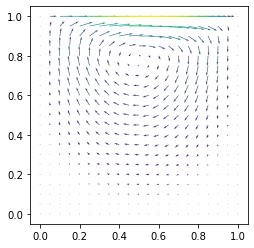

In [2]:
up_ = Function(VQ)
bc0 = DirichletBC(VQ.sub(0), Expression(("x[0]*(1-x[0])", "0"), degree=0), "std::abs(x[1])>1-1e-12 && on_boundary")
bc1 = DirichletBC(VQ.sub(0), Constant((0, 0)), "std::abs(x[0]*(1-x[0])*x[1])<1e-12 && on_boundary")
solve(lhs(F) == rhs(F), up_, bcs=[bc0, bc1])
u_, p_ = up_.split()
fig = plot(u_)

The boundary conditions will of course depend on the problem being solved. Here we have set homogeneous Dirichlet (no-slip) on three walls and a parabolic profile on top, which corresponds to a modified lid driven cavity. 
Note that boundary conditions for velocity are set using `VQ.sub(0)`, where `sub(0)` corresponds to subspace 0 of the mixed `VQ` space. A Dirichlet boundary condition on pressure could have been set using `VQ.sub(1)`, but here that would be an over-specification. 

The stream function $\psi(\boldsymbol{x}, t)$ was defined in Eq. {eq}`eq:streamfunction2D` in [Similarity solutions](similarity.ipynb). The Poisson equation {eq}`eq:Eqstreamfunction2D` for the streamfunction, can be transformed to a variational form by multiplying with a `TestFunction` $\psi_v$ and then integrating over the domain using integration by parts

```{math}
\begin{aligned}
  \int_{\Omega} \psi_v \nabla^2 \psi \mathrm{d} x &= -\int_{\Omega} \psi_v \omega_z \mathrm{d}x, \notag \\
  -\int_{\Omega} \nabla (\psi_v) \cdot \nabla (\psi) \mathrm{d}x + \int_{\Gamma} \psi_v \nabla \psi \cdot \boldsymbol{n} \mathrm{d}s &= -\int_{\Omega} \psi_v \omega_z \mathrm{d}x. \label{eq:FormStreamfunction}
\end{aligned}
```

Here $\boldsymbol{n}$ is the normal vector pointing outwards from the external boundary. The normal can be used directly in FEniCS forms through, e.g., `n=FacetNormal(mesh)`.

By taking the curl of the momentum equation {eq}`eq:Stokes` and using that the curl of a gradient is always zero, an equation for the vorticity vector $\boldsymbol{\omega}$ is obtained

```{math}
  \nabla^2 \boldsymbol{\omega} = 0.
```

Likewise, by taking the divergence (not gradient as it says in White {cite}`white06`) of the momentum equation {eq}`eq:Stokes` we obtain an equation for the pressure

```{math}
  \nabla^2 p = 0,
```

which follows since $\nabla \cdot \nabla^2 \boldsymbol{u} = \nabla^2 (\nabla \cdot \boldsymbol{u})=0$. For Stokes flow both the pressure and the vorticity are governed by homogeneous Laplace equations. For 2D flows we also know the equation for the streamfunction $\nabla^2 \psi = -\omega_z$. Inserting this into the Laplace equation for $\omega_z$ we obtain

```{math}
  \nabla^4 \psi = 0,
```

which is a biharmonic equation for the streamfunction. Obviously, if $\psi$ is a solution to $\nabla^4 \psi = 0$, then $-\psi$ is a solution as well. In other words, the direction of flow along a streamline is arbitrary and only fixed due to boundary conditions. Reversing the direction of the flow (like we do in the mandatory assignment) will not change the streamlines, but the values will get the opposite sign.

Stokes paradox states that it is not possible to obtain steady solutions to $\nabla^4 \psi = 0$ for 2D flows with both free stream and no-slip boundary conditions. Stokes paradox is, like d'Alembert's
paradox, really only a paradox because the equations do not represent real physical flow, just approximations in the limit. It follows from Stokes paradox that inertia can never be neglected for 2D flows with both free stream and no-slip boundary conditions.

## Creeping flow past a sphere

Stokes flow past a sphere of radius $a$ is a 3D flow and thus solutions to $\nabla^4 \psi = 0$ may be found even though there is no-slip on the sphere wall and free stream far away. In spherical polar coordinates the stream function, $\psi$, is defined through

```{math}
:label: eq:StreamFunctionSphere
  u_r = \frac{1}{r^2 \sin \theta} \frac{\partial \psi}{\partial \theta}, \quad u_{\theta} = -\frac{1}{r \sin \theta} \frac{\partial \psi}{\partial r}. 
```

The streamfunction equation becomes for spherical coordinates

```{math}
 \left( \frac{\partial^2 }{\partial r^2} + \frac{1}{r} \frac{\partial^2 }{\partial \theta^2} - \frac{\cot \theta}{r^2} \frac{\partial}{\partial \theta} \right)^2 \psi = 0,
```

with boundary conditions

```{math}
\begin{aligned}
  \frac{\partial \psi}{\partial r} &=  \frac{\partial \psi}{\partial \theta} = 0, \quad \text{for}\quad r=a, \\
  \psi &= \frac{1}{2} U r^2 \sin^2 \theta + \text{const}, \quad \text{for} \quad r \longleftrightarrow \infty.
\end{aligned}
```

Using separation of variables White reports that the solution to this problem reads

```{math}
  \psi = \frac{1}{4}U a^2 \sin ^2 \theta \left(\frac{a}{r} - \frac{3r}{a} + \frac{2r^2}{a^2}\right),
```

and thus we obtain the velocity components from {eq}`eq:StreamFunctionSphere`

```{math}
\begin{aligned}
  u_r &= U \cos \theta  \left(1 + \frac{a^3}{2r^3} - \frac{3a}{2r}\right), \\
  u_{\theta} &= U \sin \theta \left(-1 + \frac{a^3}{4r^3} + \frac{3a}{4r}\right)
\end{aligned}
```

A few important notes

- The velocity is independent of $\rho$ and $\mu$, which is actually true for all creeping flows.
- There is perfect symmetry of the streamlines past the sphere. No wake and no separation.
- The velocity is everywhere smaller than the free stream. This is contrary to inviscid flows where the velocity is maximum at the top and bottom of the sphere. For Stokes flow the velocity will here be zero due to no-slip.
- The effect of the sphere can be observed at enormous distances away from the sphere. At $r=10a$ the velocity is still $10 \%$ lower  than the free stream.

The pressure can be computed from the momentum equations in radial and $\theta$-direction

```{math}
\begin{aligned}
  \frac{\partial p}{\partial r} &= \mu \left( \nabla^2 u_r - \frac{2 u_r}{r^2} - \frac{2}{r^2}\frac{\partial u_{\theta}}{\partial \theta} - \frac{2 u_{\theta} \cot \theta}{r^2} \right), \\
  \frac{\partial p}{\partial \theta} &= \mu r \left( \nabla^2 u_{\theta} + \frac{2}{r^2}\frac{\partial u_r}{\partial \theta} - \frac{u_{\theta}}{r^2 \sin^2 \theta} \right)
\end{aligned}
```

Insert for $u_r$ and $u_{\theta}$ and integrate both equations, using boundary conditions, to obtain

```{math}
:label: eq:PressureSphere
  p(r, \theta) = p_{\infty} - \frac{3 \mu a U}{2 r^2} \cos \theta,
```

where $p_{\infty}$ is the pressure in the free stream. From {eq}`eq:PressureSphere` it is evident that the pressure is highest at the front (left hand side) of the sphere where $\theta=\pi$, and lowest at the rear where $\theta=0$. The pressure difference sets up a force acting on the sphere in the streamwise direction. The total force acting on the sphere is a vector that can be computed as

```{math}
  \boldsymbol{F} = \int_{\Gamma} \tau \cdot \boldsymbol{n}\, \mathrm{d}A,
```

where as before the total stress is composed of pressure and friction  through the stress tensor $\tau=-p \boldsymbol{I}+\mu(\nabla \boldsymbol{u}+\nabla \boldsymbol{u}^T)$. The normal to the surface of the sphere is everywhere aligned with the $r$-direction such that we can write

```{math}
\begin{aligned}
  \boldsymbol{F_p} + \boldsymbol{F_{\tau}} &= \int_{\Gamma} \left(-p \boldsymbol{I} +\mu  (\nabla  \boldsymbol{u} + \nabla  \boldsymbol{u}^T) \right) \cdot \boldsymbol{n}\, \mathrm{d}A, \\
  &= \int_{0}^{\pi} (\tau_{rr} + \tau_{r\theta})2\pi a^2 \sin \theta \mathrm{d} \theta,
\end{aligned}
```

where $\tau_{rr}$ and $\tau_{r\theta}$ are the pressure and friction stresses respectively. This follows since the pressure force is always acting normal to the plane and shear acts in the tangent plane. Remember that $\tau_{ij}$ is a force acting in the $j$-direction on a plane having $i$ as the normal direction.

The pressure has already been computed. The remaining shear stress can be computed in spherical coordinates as

```{math}
\begin{aligned}
  \tau_{r\theta} &= \mu \left( \frac{1}{r} \frac{\partial u_r}{\partial \theta} + \frac{\partial u_{\theta}}{\partial r} - \frac{u_{\theta}}{r} \right), \\
  &= -\frac{\mu U \sin \theta}{r} \frac{3 a^3}{2 r^3}.
\end{aligned}
```

The total force acting in the streamwise direction is computed by inserting for $\tau_{rr}$ and $\tau_{r\theta}$ leading to two simple integral as

```{math}
\begin{aligned}
  F_{x} &= |\boldsymbol{F_p}| \cos \theta + |\boldsymbol{F_{\tau}}| \sin \theta \\
        &= 3 \mu U \pi a \left(\frac{2}{3} + \frac{4}{3} \right), \\
        &= 6 \mu \pi U a.
\end{aligned}
```

In other words, the drag force consists of 2/3 friction and 1/3 pressure.



```{bibliography} ../../references.bib
:filter: docname in docnames
```